<h1 align="center"> Statistics and Financial Data Science </h1>




GARCH examples
===

In [44]:
%reset -f

In [45]:
#import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import pandas_datareader as pd_data

In [46]:
# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

In [47]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm 
from datetime import datetime
# For splines
import patsy
from patsy import dmatrix
from arch import arch_model
from arch.univariate import ARX
from arch.univariate import GARCH
import pandas_datareader.data as web
import datetime as dt
import scipy.stats as st

In [48]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [49]:

def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,10)#package version
    
    ax4.plot(ljbox_test[1])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()
    
    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Resid Sqr")
    
    plt.tight_layout()

In [50]:
start = dt.datetime(2007,1,1)
end = dt.datetime(2019,11,26)
AAPL = web.get_data_yahoo('AAPL', start=start, end=end)
AAPL.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-20,66.519997,65.099998,66.385002,65.797501,106234400.0,64.704376
2019-11-21,66.002502,65.294998,65.922501,65.502502,121395200.0,64.414268
2019-11-22,65.794998,65.209999,65.647499,65.445000,65325200.0,64.357727
2019-11-25,66.610001,65.629997,65.677498,66.592499,84020400.0,65.486168
2019-11-26,66.790001,65.625000,66.735001,66.072502,105207600.0,64.974815


In [51]:
# Let's look at the returns
AAPLRet = np.log(AAPL['Adj Close']).diff().dropna()
AAPLRet.head()

Date
2007-01-04    0.021953
2007-01-05   -0.007147
2007-01-08    0.004926
2007-01-09    0.079800
2007-01-10    0.046746
Name: Adj Close, dtype: float64

1) Plot ACF/PACF for first impression on autoregressive features

2) Test for stationarity (otherwise transform)

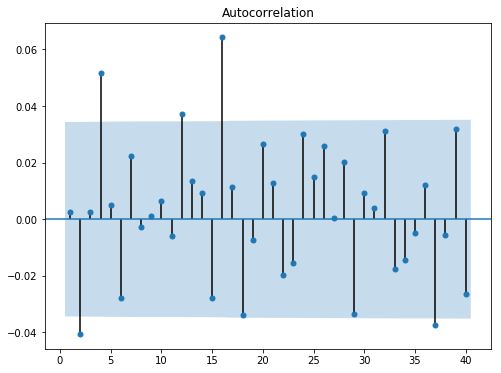

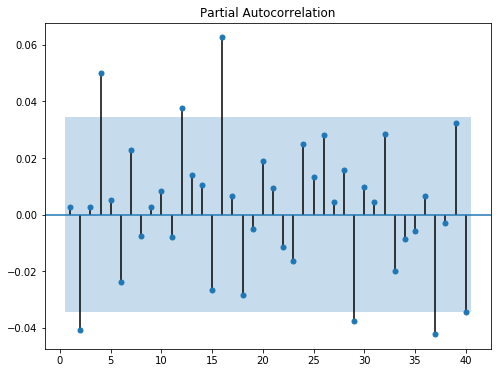

In [52]:
plot_acf(AAPLRet,zero = False, lags = 40);
plot_pacf(AAPLRet, zero = False, lags =40);
plt.show()

Data passes the stationarity tests - I can consider modelling as an ARMA process
===

In [53]:
# Reject Unit Root
test = adfuller(AAPLRet, maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -27.638172
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [54]:
# Kpss test supports stationarity
num = len(AAPLRet)
maxLag = np.log(num)
test = kpss(AAPLRet, lags = int(maxLag)) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.059144
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


3) Find / fit best ARMA model (already differenced once).

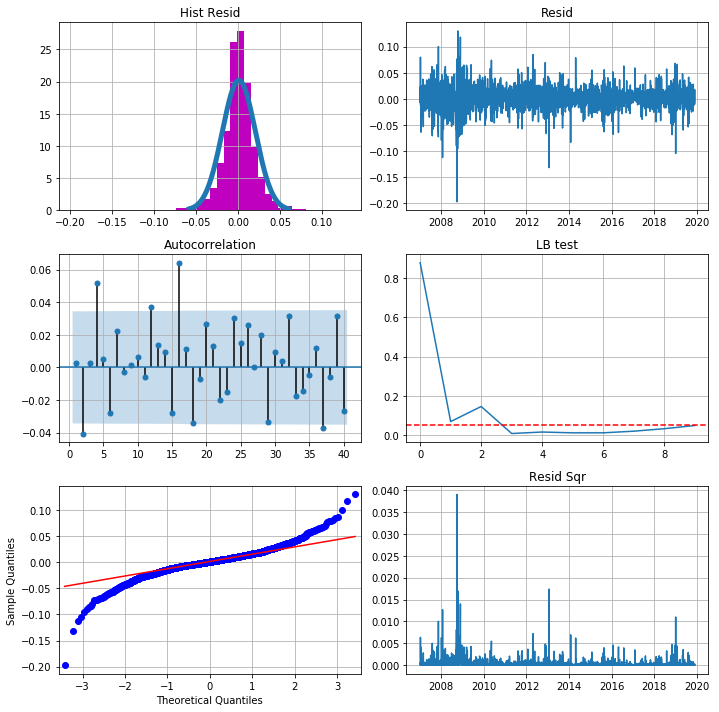

In [55]:
# Just plotting graphs on the actual data and examining the results fo the Ljung-Box test...
# I see that there is auto-correlation

plot_diagnosticsTight3(AAPLRet)

In [56]:
# Define a very simple function to searhch for models - will have to be flexible, given that
# Python arch_model does not take as mean the ARMA model, but only ARX model...
# When possible, will choose simpler models.

def searchARMA(data, exog, max_p, max_q):
 
    aic = np.zeros((max_p,max_q))
    for i in range(max_p):
        for j in range(max_q):
            try:
                if(len(exog) == len(data)):
                    model = ARMA(data,(i,j), exog = exog) 
                else:
                     model = ARMA(data,(i,j)) 
                res = model.fit(trend='nc')
                aic[i,j] = res.aic
                print('p:',i,' q:', j,' aic:', aic[i,j])
            except:
                continue

In [57]:
# So can fit an ARMA type model
results = pm.auto_arima(AAPLRet, trace = True, seasonal=False, with_intercept=True, start_q=0, max_p = 6, max_q = 6,d=0) #d = 1
# Order selected is given in summary
print(results.summary())
# This chooses AR 4 model for the mean

Fit ARIMA: order=(2, 0, 0); AIC=-16274.785, BIC=-16250.442, Fit time=0.069 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-16273.410, BIC=-16261.238, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-16271.433, BIC=-16253.176, Fit time=0.028 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-16271.435, BIC=-16253.178, Fit time=0.024 seconds
Fit ARIMA: order=(3, 0, 0); AIC=-16272.807, BIC=-16242.378, Fit time=0.091 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-16272.791, BIC=-16242.362, Fit time=0.258 seconds
Fit ARIMA: order=(3, 0, 1); AIC=-16274.819, BIC=-16238.304, Fit time=1.271 seconds
Fit ARIMA: order=(4, 0, 1); AIC=-16277.016, BIC=-16234.415, Fit time=0.684 seconds
Fit ARIMA: order=(4, 0, 0); AIC=-16278.970, BIC=-16242.455, Fit time=0.198 seconds
Fit ARIMA: order=(5, 0, 1); AIC=-16276.551, BIC=-16227.865, Fit time=1.246 seconds
Fit ARIMA: order=(5, 0, 0); AIC=-16277.058, BIC=-16234.457, Fit time=0.275 seconds
Total fit time: 4.151 seconds
                              ARMA Model Results         

In [58]:
# Unsurprisingly, same here

exog = np.arange(1)
searchARMA(AAPLRet, exog, max_p=6, max_q = 1)

p: 1  q: 0  aic: -16265.252451486536
p: 2  q: 0  aic: -16267.940325912845
p: 3  q: 0  aic: -16266.032533226193
p: 4  q: 0  aic: -16273.02920104569
p: 5  q: 0  aic: -16271.214001529373


3b) Just repeating results in SARIMAX to get functions from this class


In [59]:
model = sm.tsa.SARIMAX(AAPLRet, order=(4, 0, 0), trend='c')
fit = model.fit()
print(fit.summary());

                           Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                 3248
Model:               SARIMAX(4, 0, 0)   Log Likelihood                8145.485
Date:                Thu, 19 Nov 2020   AIC                         -16278.970
Time:                        09:38:30   BIC                         -16242.455
Sample:                             0   HQIC                        -16265.888
                               - 3248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.733      0.006       0.000       0.002
ar.L1          0.0027      0.011      0.249      0.804      -0.019       0.024
ar.L2         -0.0385      0.012     -3.139      0.0

We notice a few points about this model"
- Coeff phi_1 and phi_3 seem not to be statistically signficant. 
- In fact, all coefficients are very small .... 
- This can also be observed as per the order of the ACF in the plots.
- For the moment, will work with this model, but we are aware that perhaps, a constant mean model 
- combined with perhaps a GARCH model might be suitable.

4) Plot Diagnostics on residuals of the model

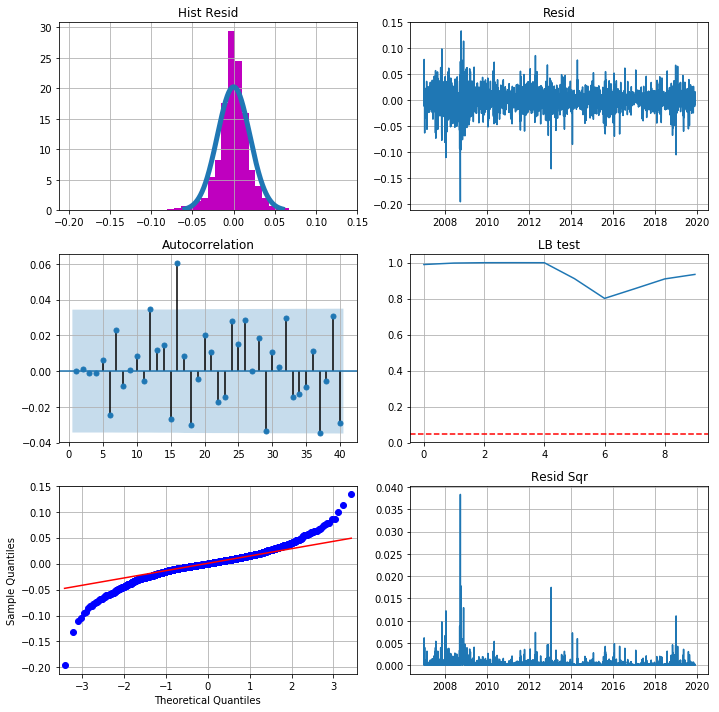

In [60]:
plot_diagnosticsTight3(fit.resid)

Even though there is no auto-correlation and residuals pass the Ljung-Box test, there seem to be clusters 
in the data and also the QQ plot does not fit with normality. There could be due to heteroskedasticity - so we examine
the squared residulas

5) Check squared residuals ACF/PACF - these indicate some AR with order maybe 5 - 9, depending on how complex we wish model to be.

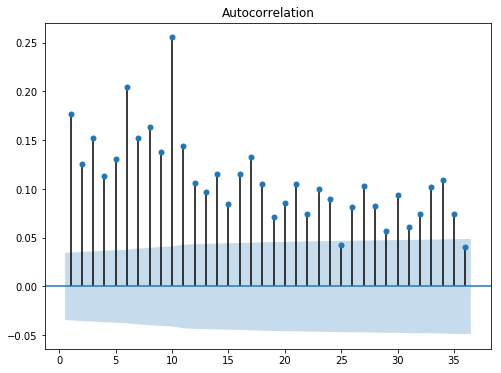

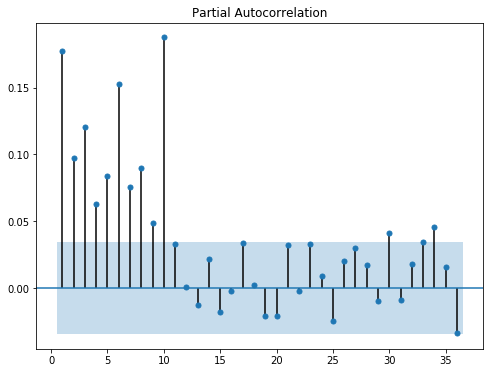

In [61]:
plot_acf(fit.resid**2, zero = False);
plot_pacf(fit.resid**2, zero = False);
plt.show()

In [62]:
# Above were examples with SARIMAX which are familiar with. In arch_model we need to
# specify a mean model using a different method - this is restricted to AR type only, with 
# potential external regressors.

6) Combine the models by specifying the mean and vol processes into a GARCH model:

In [63]:
# The model allows us to choose specific lags - this is very similar to the SARIMAX function from statsmodels:
# Diff are possibly due to numerical approx / methods/ tolerance

newAAPLRet = AAPLRet
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(5,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8320.790433430995
            Iterations: 3
            Function evaluations: 66
            Gradient evaluations: 3
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                       0.004
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:                8320.79
Distribution:                  Normal   AIC:                          -16619.6
Method:            Maximum Likelihood   BIC:                          -16552.7
                                        No. Observations:                 3244
Date:                Thu, Nov 19 2020   Df Residuals:                     3233
Time:                        09:38:33   Df Model:                           11
                                   Mean Model                                  


- I'm suspiscious on the convergence of the model as all alphas are the same. 
- We can try using the rescale function to see if we obtain an improvement or
- We can try to scale the returns (by x 100)... let's try both and watch the effect on coefficients

In [64]:
newAAPLRet =AAPLRet*100
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(5,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6470.784675298437
            Iterations: 23
            Function evaluations: 330
            Gradient evaluations: 23
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.003
Mean Model:                        AR   Adj. R-squared:                 -0.004
Vol Model:                       ARCH   Log-Likelihood:               -6470.78
Distribution:                  Normal   AIC:                           12963.6
Method:            Maximum Likelihood   BIC:                           13030.5
                                        No. Observations:                 3244
Date:                Thu, Nov 19 2020   Df Residuals:                     3233
Time:                        09:38:34   Df Model:                           11
                                   Mean Model                                 

7) Analyse outputs and consider diagnostics of model

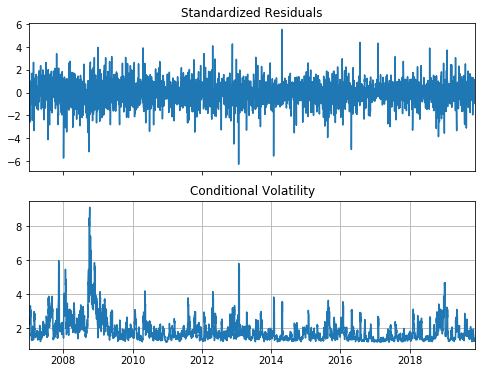

In [65]:
# Exploring the outputs
res.plot()
plt.grid()
plt.show()

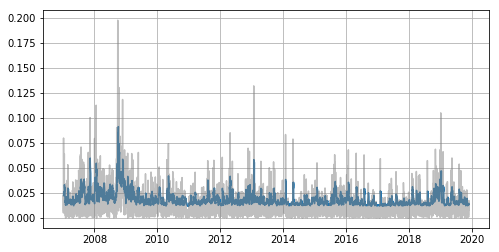

In [66]:
# Plot conditional vol vs abs(ret)
plt.figure(1, figsize=(8,4))
plt.plot(res.conditional_volatility/100)
plt.plot(abs(AAPLRet), color = 'grey', alpha = 0.5)
plt.grid()
plt.show()

7) Consider Diagnostics of StdResiduals: Ljung-Box tests to verify no autocorrelation and normality tests

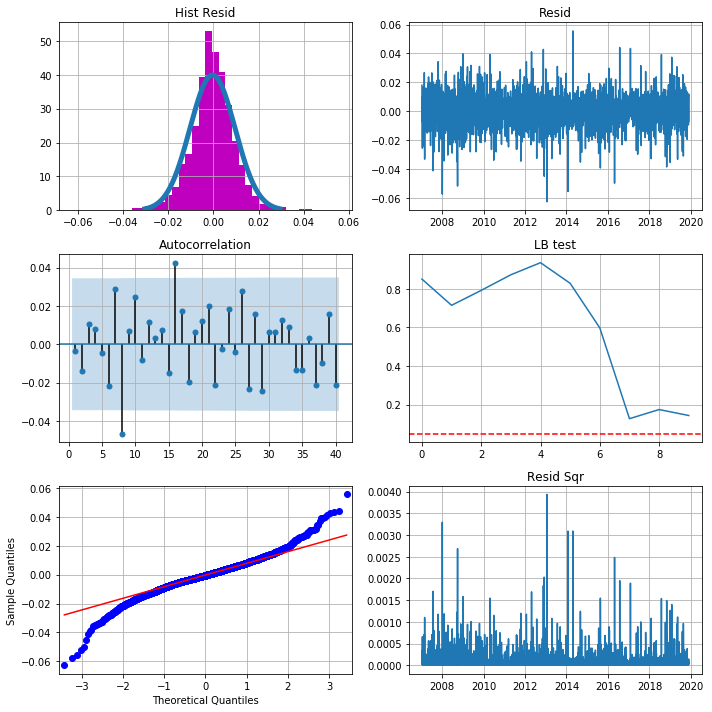

In [67]:
std_resid = res.resid/100/res.conditional_volatility
std_resid = std_resid.dropna()
plot_diagnosticsTight3(std_resid)

- The standardized residuals have passed the Ljung-Box test, supporting the case that they are white noise
- However, the QQ plot still does not seem to fit a normal, potentially a different distribution shoudl be considered.
- We should verify by formal normality tests: both reject hypothesis of normality.

In [68]:
JB_test = stats.jarque_bera(std_resid)
print('Jarque-Bera statitiscs: ', JB_test[0])
print('Jarque-Bera p-value: ', JB_test[1])

Jarque-Bera statitiscs:  1268.5349312012233
Jarque-Bera p-value:  0.0


In [69]:
shap_test = stats.shapiro(std_resid)
print('Shapiro statitiscs: ', shap_test[0])
print('Shapiro p-value: ', shap_test[1])

Shapiro statitiscs:  0.9698940515518188
Shapiro p-value:  1.4558832297067699e-25


8) Forecasting using the model

<img src="ARCHPic.png" width="1000">

Here the notatios follows the convention say for GARCH(1,1) with constant mean:

$$r_t = \mu + \epsilon_t$$
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma^2_{t-1}$$
$$ \epsilon_t = \sigma_t e_t, \quad \ e_t \sim N(0,1)$$